# Two Gaussian distributions in 4D

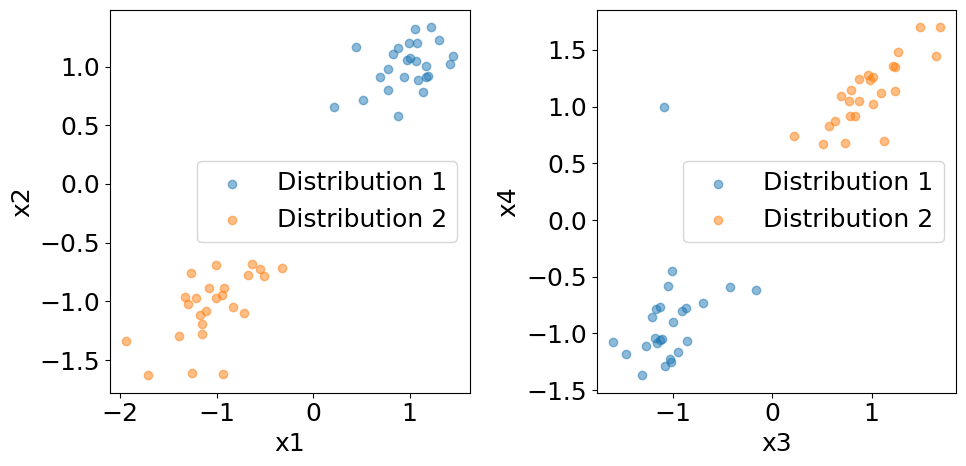

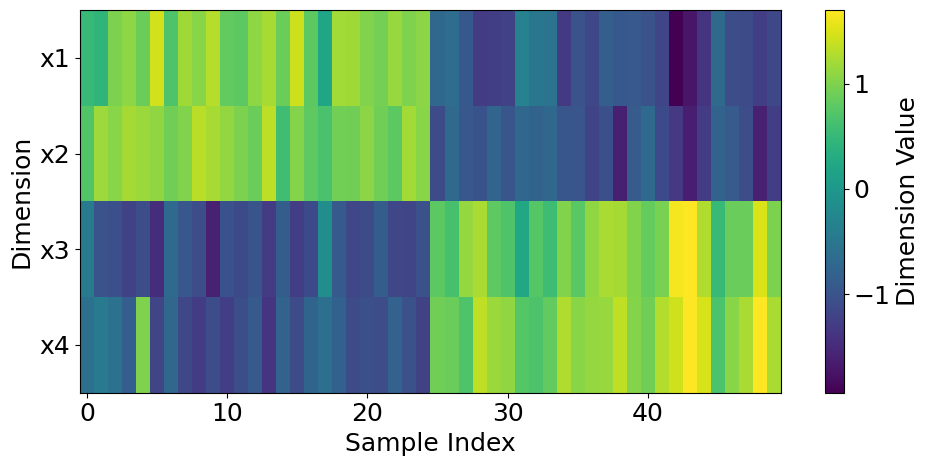

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set figure font size
plt.rcParams.update({'font.size': 18})

# Generate synthetic 4D data with specific correlations
np.random.seed(1)

# First distribution parameters
n1 = 25
mean1 = np.array([1, 1, -1, -1])  # Positive x1,x2, negative x3,x4
cov1 = np.array([
    [1.0, 0.5, -0.7, -0.7],
    [0.5, 1.0, -0.7, -0.7],
    [-0.7, -0.7, 1.0, 0.5],
    [-0.7, -0.7, 0.5, 1.0]
])
cov1 = 0.1*cov1
samples1 = np.random.multivariate_normal(mean1, cov1, n1)

# Second distribution parameters
n2 = 25
mean2 = np.array([-1, -1, 1, 1])  # Negative x1,x2, positive x3,x4
cov2 = np.array([
    [1.0, 0.5, -0.7, -0.7],
    [0.5, 1.0, -0.7, -0.7],
    [-0.7, -0.7, 1.0, 0.5],
    [-0.7, -0.7, 0.5, 1.0]
])
cov2 = 0.1*cov2
samples2 = np.random.multivariate_normal(mean2, cov2, n2)

# Combine samples
X = np.vstack([samples1, samples2])

# Create an outlier 
outlier_idx = 4 
X[outlier_idx, 3] = 1  # Set an extreme value 

# Visualize the correlations
plt.figure(figsize=(10, 5))

# Plot first two dimensions
plt.subplot(121)
plt.scatter(X[:n1, 0], X[:n1, 1], alpha=0.5, label='Distribution 1')
plt.scatter(X[n1:, 0], X[n1:, 1], alpha=0.5, label='Distribution 2')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()

# Plot last two dimensions
plt.subplot(122)
plt.scatter(X[:n1, 2], X[:n1, 3], alpha=0.5, label='Distribution 1')
plt.scatter(X[n1:, 2], X[n1:, 3], alpha=0.5, label='Distribution 2')
plt.xlabel('x3')
plt.ylabel('x4')
plt.legend()

plt.tight_layout()


# Replot the heatmap with the outlier
plt.figure(figsize=(10, 5))
plt.imshow(X.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Dimension Value')
plt.xlabel('Sample Index')
plt.ylabel('Dimension')
plt.yticks(range(4), ['x1', 'x2', 'x3', 'x4'])

plt.tight_layout()

# PCA Autoencoder

In [2]:
# Mean normalize the data
X_mean = np.mean(X, axis=0)
X_n = X - X_mean

Epoch [10/300], Loss: 0.4713
Epoch [20/300], Loss: 0.3416
Epoch [30/300], Loss: 0.2447
Epoch [40/300], Loss: 0.1760
Epoch [50/300], Loss: 0.1282
Epoch [60/300], Loss: 0.0955
Epoch [70/300], Loss: 0.0733
Epoch [80/300], Loss: 0.0585
Epoch [90/300], Loss: 0.0488
Epoch [100/300], Loss: 0.0423
Epoch [110/300], Loss: 0.0381
Epoch [120/300], Loss: 0.0354
Epoch [130/300], Loss: 0.0336
Epoch [140/300], Loss: 0.0324
Epoch [150/300], Loss: 0.0317
Epoch [160/300], Loss: 0.0311
Epoch [170/300], Loss: 0.0308
Epoch [180/300], Loss: 0.0306
Epoch [190/300], Loss: 0.0304
Epoch [200/300], Loss: 0.0303
Epoch [210/300], Loss: 0.0302
Epoch [220/300], Loss: 0.0301
Epoch [230/300], Loss: 0.0300
Epoch [240/300], Loss: 0.0300
Epoch [250/300], Loss: 0.0299
Epoch [260/300], Loss: 0.0299
Epoch [270/300], Loss: 0.0298
Epoch [280/300], Loss: 0.0298
Epoch [290/300], Loss: 0.0298
Epoch [300/300], Loss: 0.0297


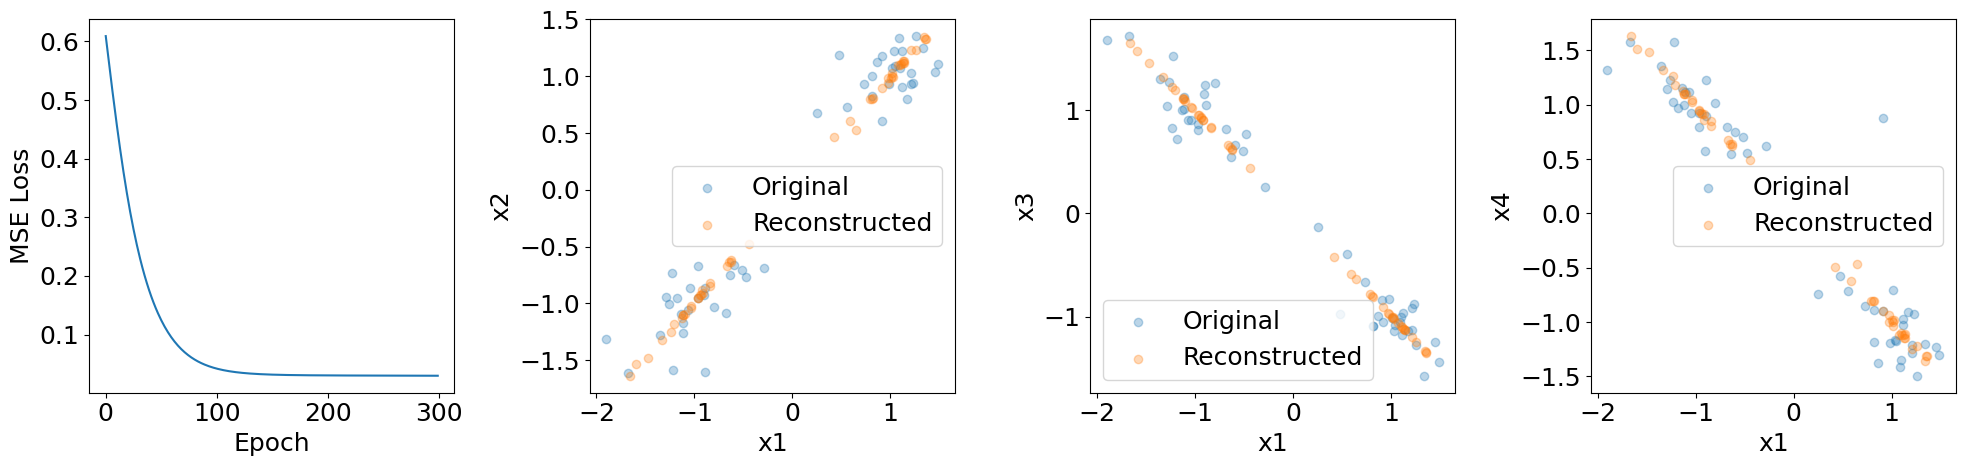

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

class PCAAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(PCAAutoencoder, self).__init__()
        # Encoder: Linear transformation to latent space
        self.encoder = nn.Linear(input_dim, latent_dim, bias=False)
        # Decoder: Transpose of encoder
        self.decoder = nn.Linear(latent_dim, input_dim, bias=False)
        
        # Tie weights of encoder and decoder (decoder's weights are encoder's transpose)
        self.decoder.weight = nn.Parameter(self.encoder.weight.t())
    
    def forward(self, x):
        # Encode and then decode
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed

# Hyperparameters
input_dim = 4  # Example input dimension
latent_dim = 2  # Dimensionality of latent space
learning_rate = 0.01
num_epochs = 300

# Convert numpy array to torch tensor
X_n_tensor = torch.from_numpy(X_n).float()  # .float() ensures it's a FloatTensor

# Model, loss, optimizer
model = PCAAutoencoder(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()
    reconstructed = model(X_n_tensor)  
    loss = criterion(reconstructed, X_n_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

with torch.no_grad():
    X_n_hat = model(X_n_tensor).numpy()
    
# Visualization
plt.figure(figsize=(20, 5))

# Plot loss curve
plt.subplot(1, 4, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

# Plot original vs reconstructed data
plt.subplot(1, 4, 2)
plt.scatter(X_n[:, 0], X_n[:, 1], alpha=0.3, label='Original')
plt.scatter(X_n_hat[:, 0], X_n_hat[:, 1], alpha=0.3, label='Reconstructed')
plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.tight_layout()

plt.subplot(1, 4, 3)
plt.scatter(X_n[:, 0], X_n[:, 2], alpha=0.3, label='Original')
plt.scatter(X_n_hat[:, 0], X_n_hat[:, 2], alpha=0.3, label='Reconstructed')
plt.xlabel('x1')
plt.ylabel('x3')
plt.legend()
plt.tight_layout()

plt.subplot(1, 4, 4)
plt.scatter(X_n[:, 0], X_n[:, 3], alpha=0.3, label='Original')
plt.scatter(X_n_hat[:, 0], X_n_hat[:, 3], alpha=0.3, label='Reconstructed')
plt.xlabel('x1')
plt.ylabel('x4')
plt.legend()
plt.tight_layout()


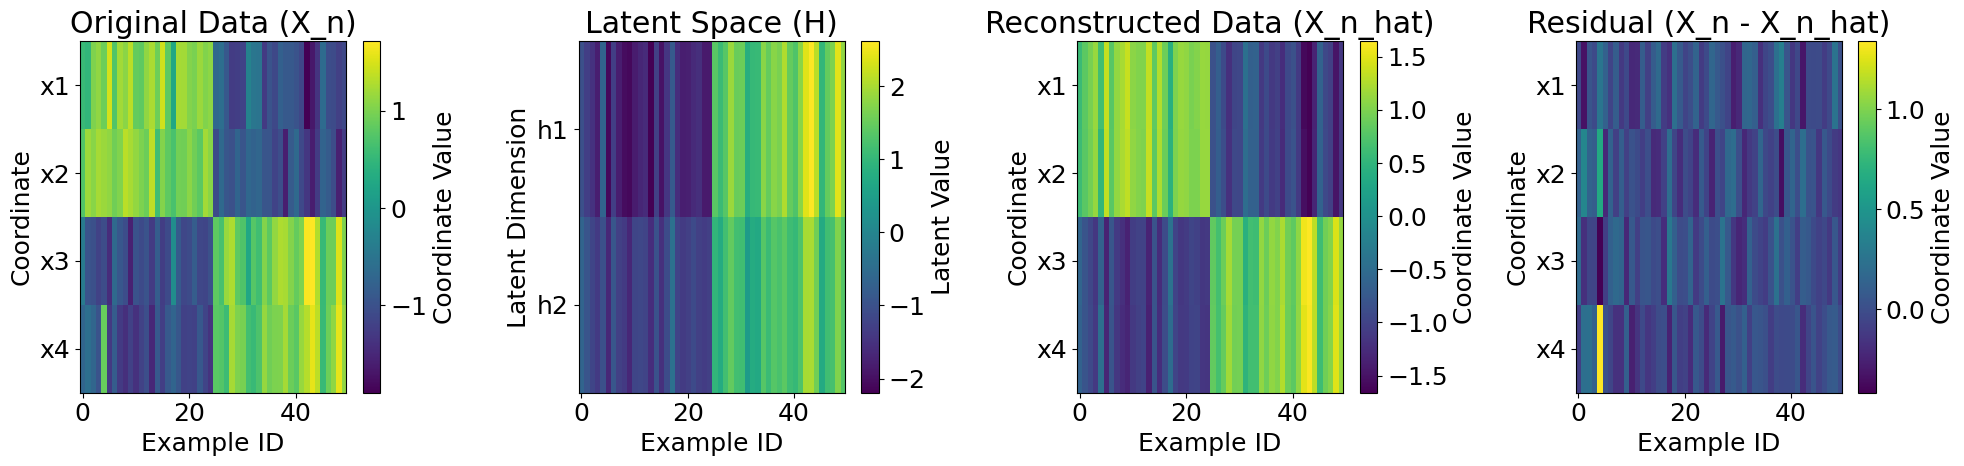

In [4]:
# Create side-by-side heatmaps of original and reconstructed data
plt.figure(figsize=(20, 5))

# Original data heatmap
plt.subplot(1, 4, 1)
plt.imshow(X_n.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Coordinate Value')
plt.xlabel('Example ID')
plt.ylabel('Coordinate')
plt.title('Original Data (X_n)')
plt.yticks(range(4), ['x1', 'x2', 'x3', 'x4'])

# Get latent representation (H)
with torch.no_grad():
    H = model.encoder(X_n_tensor).numpy()

# Plot latent representation heatmap between original and reconstructed
plt.subplot(1, 4, 2)
plt.imshow(H.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Latent Value')
plt.xlabel('Example ID')
plt.ylabel('Latent Dimension')
plt.title('Latent Space (H)')
plt.yticks(range(2), ['h1', 'h2'])

# Reconstructed data heatmap
plt.subplot(1, 4, 3)
plt.imshow(X_n_hat.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Coordinate Value')
plt.xlabel('Example ID')
plt.ylabel('Coordinate')
plt.title('Reconstructed Data (X_n_hat)')
plt.yticks(range(4), ['x1', 'x2', 'x3', 'x4'])

# ratio of original to reconstructed data
plt.subplot(1, 4, 4)
plt.imshow(X_n.T - X_n_hat.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Coordinate Value')
plt.xlabel('Example ID')
plt.ylabel('Coordinate')
plt.title('Residual (X_n - X_n_hat)')
plt.yticks(range(4), ['x1', 'x2', 'x3', 'x4'])

plt.tight_layout()